<a href="https://colab.research.google.com/github/seovalue/capstone-design-2021/blob/main/code/srcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
from google.colab import drive 
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [15]:
from google.colab import files
rc = list(files.upload().values())[0]
!unzip yang91.zip

Saving yang91.zip to yang91.zip
Archive:  yang91.zip
   creating: yang91/
  inflating: yang91/tt9.bmp          
  inflating: yang91/tt8.bmp          
  inflating: yang91/tt7.bmp          
  inflating: yang91/tt6.bmp          
  inflating: yang91/tt5.bmp          
  inflating: yang91/tt4.bmp          
  inflating: yang91/tt3.bmp          
  inflating: yang91/tt27.bmp         
  inflating: yang91/tt26.bmp         
  inflating: yang91/tt25.bmp         
  inflating: yang91/tt24.bmp         
  inflating: yang91/tt23.bmp         
  inflating: yang91/tt22.bmp         
  inflating: yang91/tt21.bmp         
  inflating: yang91/tt20.bmp         
  inflating: yang91/tt2.bmp          
  inflating: yang91/tt19.bmp         
  inflating: yang91/tt18.bmp         
  inflating: yang91/tt17.bmp         
  inflating: yang91/tt16.bmp         
  inflating: yang91/tt15.bmp         
  inflating: yang91/tt14.bmp         
  inflating: yang91/tt13.bmp         
  inflating: yang91/tt12.bmp         
  inflating: y

import libraries

In [1]:
import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Activation, Input
from keras import optimizers
from keras.models import load_model
import numpy as np
import scipy.misc
import scipy.ndimage
import cv2
import math
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import PIL
! sudo pip install --upgrade scipy==1.1.0 # for misc.imread

Requirement already up-to-date: scipy==1.1.0 in /usr/local/lib/python3.6/dist-packages (1.1.0)


build SRCNN model

In [2]:
img_shape = (32,32,1)
input_img = Input(shape=(img_shape))
C1 = Conv2D(64,(9,9),padding='SAME',name='CONV1')(input_img)
A1 = Activation('relu', name='act1')(C1)
C2 = Conv2D(32,(1,1),padding='SAME',name='CONV2')(A1)
A2 = Activation('relu', name='act2')(C2)
C3 = Conv2D(1,(5,5),padding='SAME',name='CONV3')(A2)
A3 = Activation('relu', name='act3')(C3)
model = Model(input_img, A3)
opt = optimizers.Adam(lr=0.0003)
model.compile(optimizer=opt,loss='mean_squared_error')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
CONV1 (Conv2D)               (None, 32, 32, 64)        5248      
_________________________________________________________________
act1 (Activation)            (None, 32, 32, 64)        0         
_________________________________________________________________
CONV2 (Conv2D)               (None, 32, 32, 32)        2080      
_________________________________________________________________
act2 (Activation)            (None, 32, 32, 32)        0         
_________________________________________________________________
CONV3 (Conv2D)               (None, 32, 32, 1)         801       
_________________________________________________________________
act3 (Activation)            (None, 32, 32, 1)         0     

Create function to generate High Resolution from interpolation technique to pass in SRCNN model

In [3]:
def modcrop(image, scale=2):
   if len(image.shape) == 3:
      h, w, _ = image.shape
      h = h - np.mod(h, scale)
      w = w - np.mod(w, scale)
      image = image[0:h, 0:w, :]
   else:
      h, w = image.shape
      h = h - np.mod(h, scale)
      w = w - np.mod(w, scale)
      image = image[0:h, 0:w]
   return image

In [4]:
def create_LR(image,scale):
   label_ = modcrop(image, scale)
   # Must be normalized
   label_ = label_ / 255.
   input_ = scipy.ndimage.interpolation.zoom(label_, (1./scale), prefilter=False)
   input_ = scipy.ndimage.interpolation.zoom(input_, (scale/1.), prefilter=False)
   return input_

In [45]:
path = '/content/drive/MyDrive/train/yang91/'
files_y = glob.glob(path + '*.bmp')

Split data into 3 parts, 21 images for each set.

In [46]:
trainfiles = files_y[:21]
testfiles = files_y[21:42]
valfiles = files_y[42:]

In [47]:
print(len(trainfiles), len(testfiles), len(valfiles))
print(len(files_y))

21 21 21
63


In [48]:
img_size = 32
stride = 16
scale = 4
X_train = []
Y_train = []
X_test = []
Y_test = []
X_val = []
Y_val = []

Extract patch image for test

In [49]:
for file_y in testfiles:
   tmp_y = scipy.misc.imread(file_y,flatten=True, mode='YCbCr').astype(np.float)
   tmp_X = create_LR(tmp_y,scale)
   h,w = tmp_y.shape
   for x in range(0, h-img_size+1, stride):
      for y in range(0, w-img_size+1, stride):
         sub_input = tmp_X[x:x+img_size, y:y+img_size].reshape(img_size,img_size,1) # [32 x 32]
         sub_label = tmp_y[x:x+img_size, y:y+img_size].reshape(img_size,img_size,1) # [32 x 32]
         X_test.append(sub_input)
         Y_test.append(sub_label)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  


Extract patch image for training

In [50]:
for file_y in trainfiles:
   tmp_y = scipy.misc.imread(file_y,flatten=True, mode='YCbCr').astype(np.float)
   tmp_X = create_LR(tmp_y,scale)
   h,w = tmp_y.shape
   for x in range(0, h-img_size+1, stride):
      for y in range(0, w-img_size+1, stride):
         sub_input = tmp_X[x:x+img_size, y:y+img_size].reshape(img_size,img_size,1)
         sub_label = tmp_y[x:x+img_size, y:y+img_size].reshape(img_size,img_size,1)
         X_train.append(sub_input)
         Y_train.append(sub_label)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  


Extract patch image for validation

In [51]:
for file_y in valfiles:
   tmp_y = scipy.misc.imread(file_y,flatten=True, mode='YCbCr').astype(np.float)
   tmp_X = create_LR(tmp_y,scale)
   h,w = tmp_y.shape
   for x in range(0, h-img_size+1, stride):
      for y in range(0, w-img_size+1, stride):
         sub_input = tmp_X[x:x+img_size, y:y+img_size].reshape(img_size,img_size,1) # [32 x 32]
         sub_label = tmp_y[x:x+img_size, y:y+img_size].reshape(img_size,img_size,1) # [32 x 32]
         X_val.append(sub_input)
         Y_val.append(sub_label)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  


In [52]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_val = np.array(X_val)
Y_val = np.array(Y_val)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [53]:
model.fit(X_train, Y_train, batch_size = 128, epochs = 30, validation_data=(X_val, Y_val))

Epoch 1/30
45/45 [==============================] - 1s 17ms/step - loss: 297.2181 - val_loss: 421.4962
Epoch 2/30
45/45 [==============================] - 1s 13ms/step - loss: 291.8391 - val_loss: 416.2883
Epoch 3/30
45/45 [==============================] - 1s 12ms/step - loss: 286.8717 - val_loss: 411.6148
Epoch 4/30
45/45 [==============================] - 1s 12ms/step - loss: 282.5495 - val_loss: 406.9203
Epoch 5/30
45/45 [==============================] - 1s 12ms/step - loss: 278.4712 - val_loss: 403.8064
Epoch 6/30
45/45 [==============================] - 1s 13ms/step - loss: 274.7204 - val_loss: 398.5493
Epoch 7/30
45/45 [==============================] - 1s 12ms/step - loss: 271.3418 - val_loss: 395.2352
Epoch 8/30
45/45 [==============================] - 1s 13ms/step - loss: 268.5424 - val_loss: 392.2312
Epoch 9/30
45/45 [==============================] - 1s 12ms/step - loss: 265.9456 - val_loss: 389.9028
Epoch 10/30
45/45 [==============================] - 1s 12ms/step - loss:

In [54]:
model.save('srcnn.h5')

In [55]:
print(Y_train[0].shape)

(32, 32, 1)


In [56]:
prediction = np.array(model.predict(X_test[0]))

In [57]:
print(prediction.shape)

(32, 32, 1, 1)


In [22]:
print(type(prediction))

<class 'numpy.ndarray'>


In [58]:
img_o = scipy.misc.imread('/content/drive/MyDrive/train/baby_x2_GT.png',flatten=True,mode='YCbCr').astype(np.float)
img = create_LR(img_o,2) #################################################################SCALE#################
img_size = 32
stride = 16
h,w = img.shape
piece_wise = []
for x in range(0, h-img_size+1, stride):
    for y in range (0, w-img_size+1, stride):
        sub_input = img[x:x+img_size, y:y+img_size].reshape(img_size,img_size,1)
        piece_wise.append(sub_input)
input_ = np.asarray(piece_wise)
srcnn = load_model('srcnn.h5')
hat = srcnn.predict(input_)
img_re = np.zeros(img.shape)
i = 0
for x in range(0, h-img_size+1, stride):
    for y in range (0, w-img_size+1, stride):
        img_re[x:x+img_size, y:y+img_size] = hat[i].reshape(img_size,img_size)
        i += 1
cv2.imwrite('restored.bmp', img_re)
cv2.imwrite('original.bmp', img_o)
img_save = (img*255).astype(np.uint8)
cv2.imwrite('blurred.bmp',img_save)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


True

In [59]:
#CALCULATE PSNR
original = cv2.imread("original.bmp")
LR       = cv2.imread("blurred.bmp")
contrast = cv2.imread("restored.bmp",1)
def psnr(img1, img2):
    mse = np.mean((img1-img2)**2)
    if mse ==0:
        return 100
    PIXEL_MAX = 255.0
    return 20* math.log10(PIXEL_MAX / math.sqrt(mse))
d = psnr(original,contrast)
print(d)

32.94133885816566


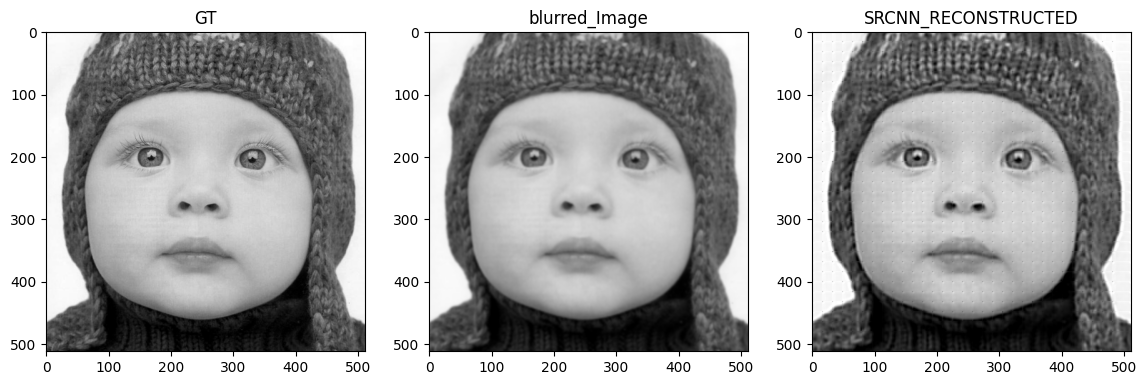

In [60]:
fig = plt.figure(figsize = (14,14), dpi = 100)
ax = plt.subplot("131")
ax.imshow(original)
ax.set_title("GT")
plt.grid(0)

ax = plt.subplot("132")
ax.imshow(LR)
ax.set_title("blurred_Image")
plt.grid(0)

ax = plt.subplot("133")
ax.imshow(contrast)
ax.set_title("SRCNN_RECONSTRUCTED")
plt.grid(0)
plt.show()